# **Point Net - Classification**

In [1]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3

from open3d.web_visualizer import draw # for non Colab
import os, os.path as osp

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
NUM_TRAIN_POINTS = 2500
NUM_TEST_POINTS = 10000
NUM_CLASSES = 16
GLOBAL_FEATS = 1024
BATCH_SIZE = 32
CATEGORIES = {
    'Airplane': 0, 
    'Bag': 1, 
    'Cap': 2, 
    'Car': 3,
    'Chair': 4, 
    'Earphone': 5, 
    'Guitar': 6, 
    'Knife': 7, 
    'Lamp': 8, 
    'Laptop': 9,
    'Motorbike': 10, 
    'Mug': 11, 
    'Pistol': 12, 
    'Rocket': 13, 
    'Skateboard': 14, 
    'Table': 15}
            
ROOT = osp.abspath("shapenet_like_out")

In [3]:
# https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip

In [4]:
from torch.utils.data import DataLoader
from foil_dataset import convert_to_shapenet_like

npoints = 10000
convert_to_shapenet_like(npoints=npoints, manifest_keys = ["full_train","full_test"]) # the full train set
# convert_to_shapenet_like(npoints=npoints, manifest_key = "full_test",) # the full test set


Converting to ShapeNet-like: 100%|██████████| 1000/1000 [09:18<00:00,  1.79it/s]

[OK] Test set prêt dans: c:\Users\romai\OneDrive\Bureau\EPFL\MA3\Project\ResearchProject\3D\point_net\shapenet_like_out
  Catégorie: Airplane -> 0
  Exemples (objets): 1000 | npoints/objet: 10000


{'root_out': 'c:\\Users\\romai\\OneDrive\\Bureau\\EPFL\\MA3\\Project\\ResearchProject\\3D\\point_net\\shapenet_like_out',
 'tokens': ['0/airFoil2D_SST_36.622_11.319_3.941_5.424_1.0_16_3',
  '0/airFoil2D_SST_58.831_-3.563_2.815_4.916_10_3',
  '0/airFoil2D_SST_43.327_8.905_4.236_6.511_10_3',
  '0/airFoil2D_SST_89.151_4.462_0.974_4.094_1.0_19_3',
  '0/airFoil2D_SST_87.422_2.992_1.895_3.128_1.0_10_3',
  '0/airFoil2D_SST_42.531_-3.927_1.264_6.838_0.0_7_3',
  '0/airFoil2D_SST_46.246_9.78_3.769_2.353_17_3',
  '0/airFoil2D_SST_67.481_-1.259_5.136_2.438_18_3',
  '0/airFoil2D_SST_45.701_-1.925_0.671_7.455_0.0_12_3',
  '0/airFoil2D_SST_85.488_6.826_3.112_3.445_1.0_17_3',
  '0/airFoil2D_SST_56.177_2.108_1.208_3.592_0.0_14_3',
  '0/airFoil2D_SST_46.0_-0.095_2.322_1.874_16_3',
  '0/airFoil2D_SST_81.846_10.688_0.402_4.721_0.0_11_3',
  '0/airFoil2D_SST_56.749_1.468_1.967_7.293_1.0_8_3',
  '0/airFoil2D_SST_41.403_-2.446_1.908_4.316_0.0_5_3',
  '0/airFoil2D_SST_44.858_13.36_1.546_3.174_1.0_10_3',
  '0/a

In [5]:
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset


# test Dataset & DataLoader 
test_dataset = ShapenetDataset(ROOT, npoints=npoints, split='test', classification=True, normalize=False) #already normalized in convert_to_shapenet_like, see later if we keep it like that or not
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Classification of the test set:
We verify that all the labels of the test set are 0 (Airplane arbitrarely)

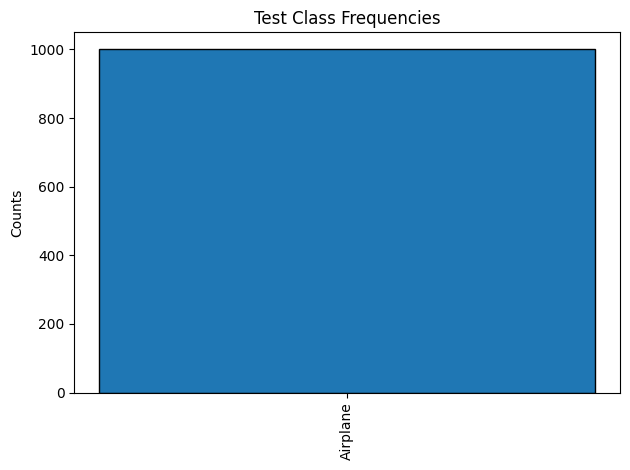

In [6]:
# collect labels from the loader
all_targets = []
for _, targets in test_dataloader:           # classification=True loader: (_, cls)
    all_targets.extend(targets.squeeze(1).cpu().numpy().tolist())

# get class names in index order from the dataset
idx_by_name = sorted(test_dataset.classes.items(), key=lambda kv: kv[1])
class_names = [name for name, _ in idx_by_name]
num_classes = len(class_names)

# bincount with correct length
class_bins = np.bincount(all_targets, minlength=num_classes)

# plot
plt.bar(class_names, class_bins, edgecolor='black')
plt.xticks(class_names, class_names, rotation=90)
plt.ylabel('Counts')
plt.title('Test Class Frequencies')
plt.tight_layout()
plt.show()


In [7]:
from point_net import PointNetClassHead
classifier35 = PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## Test Model performance cls_model_35
We play with this model, loading it and looking at its predictions (obviously very bad as the groundtruth of the test set was selected arbitrarily)

In [9]:
from point_net import PointNetClassHead
MODEL_PATH = 'trained_models/cls_focal_clr/cls_model_35.pth'

classifier35 = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier35.load_state_dict(torch.load(MODEL_PATH))
classifier35.eval();

In [10]:
import torch.optim as optim
from point_net_loss import PointNetLoss

EPOCHS = 100
LR = 0.0001
REG_WEIGHT = 0.001 

# manually downweight the high frequency classes
alpha = np.ones(NUM_CLASSES)
alpha[0] = 0.5  # airplane
alpha[4] = 0.5  # chair
alpha[-1] = 0.5 # table

gamma = 2

optimizer35 = optim.Adam(classifier35.parameters(), lr=LR)
scheduler35 = torch.optim.lr_scheduler.CyclicLR(optimizer35, base_lr=0.0001, max_lr=0.01, 
                                              step_size_up=2000, cycle_momentum=False)
criterion35 = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(DEVICE)

classifier35 = classifier35.to(DEVICE)

mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

def train_test(classifier, dataloader, num_batch, epoch, split='train'):
    ''' Function to train or test the model '''
    _loss = []
    _accuracy = []
    _mcc = []

    # return total targets and predictions for test case only
    total_test_targets = []
    total_test_preds = [] 
    for i, (points, targets) in enumerate(dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer35.zero_grad()
        
        # get predicted class logits
        preds, _, A = classifier(points)

        # get loss and perform backprop
        loss = criterion35(preds, targets, A) 

        if split == 'train':
            loss.backward()
            optimizer35.step()
            scheduler35.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(BATCH_SIZE)
        mcc = mcc_metric(preds, targets)

        # update epoch loss and accuracy
        _loss.append(loss.item())
        _accuracy.append(accuracy)
        _mcc.append(mcc.item())

        # add to total targets/preds
        if split == 'test':
            total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
            total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_batch}] ' \
                  + f'{split} loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')
        
    epoch_loss = np.mean(_loss)
    epoch_accuracy = np.mean(_accuracy)
    epoch_mcc = np.mean(_mcc)

    print(f'Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} ' \
          + f'- {split} Accuracy: {epoch_accuracy:.4f} ' \
          + f'- {split} MCC: {epoch_mcc:.4f}')

    if split == 'test':
        return epoch_loss, epoch_accuracy, epoch_mcc, total_test_targets, total_test_preds
    else: 
        return epoch_loss, epoch_accuracy, epoch_mcc

In [11]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

with torch.no_grad():
    epoch_loss, \
    epoch_accuracy, \
    epoch_mcc, \
    total_test_targets, \
    total_test_preds = train_test(classifier35, test_dataloader, 
                              num_test_batch, epoch=1, 
                              split='test');

c:\Users\romai\OneDrive\Bureau\EPFL\MA3\Project\ResearchProject\3D\point_net\point_net_loss.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pn = F.softmax(predictions)


	 [1: 0/32] test loss: 634.8761 accuracy: 0.0000 mcc: 0.0000
Epoch: 1 - test Loss: 575.3323 - test Accuracy: 0.0000 - test MCC: 0.0000


Of course everything is wrong in the prediction of the class:

In [12]:
print(f'Test Loss: {epoch_loss:.4f} ' \
      f'- Test Accuracy: {epoch_accuracy:.4f} ' \
      f'- Test MCC: {epoch_mcc:.4f}')

Test Loss: 575.3323 - Test Accuracy: 0.0000 - Test MCC: 0.0000


In [13]:
from random import randrange

torch.cuda.empty_cache() # release GPU memory

# get random sample from test data 
random_idx = randrange(len(test_dataset))
points, seg = test_dataset.__getitem__(random_idx)
'''
# normalize points: it is giving nans because we are dividing by 0!
norm_points = test_dataset.normalize_points(points)
'''
with torch.no_grad():
    norm_points = points.unsqueeze(0).transpose(2, 1).to(DEVICE)
    targets = targets.squeeze().to(DEVICE)

    preds, crit_idxs, _ = classifier35(norm_points)
    preds = torch.softmax(preds, dim=1)
    pred_choice = preds.squeeze().argmax() 
    print(preds)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       device='cuda:0')


Foils in 2D are apparently looking like mugs:

In [14]:
pred_class = list(CATEGORIES.keys())[pred_choice.cpu().numpy()]
pred_prob = preds[0, pred_choice]
print(f'The predicted class is: {pred_class}, with probability: {pred_prob}')

The predicted class is: Mug, with probability: 1.0


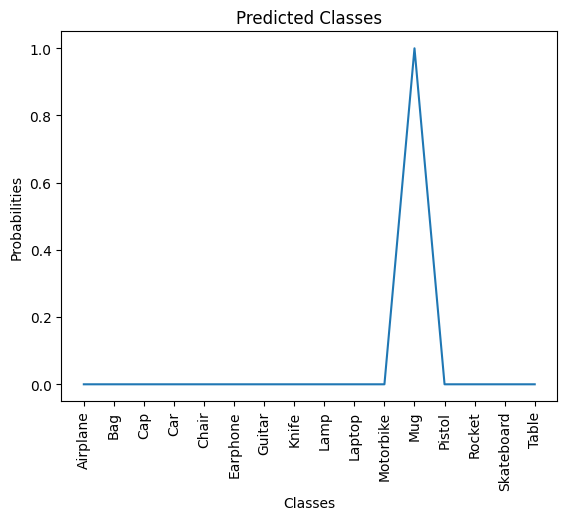

In [15]:
plt.plot(list(CATEGORIES.values()), preds.cpu().numpy()[0]);
plt.xticks(list(CATEGORIES.values()), list(CATEGORIES.keys()), rotation=90)
plt.title('Predicted Classes')
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.show()

## Now: feature extraction of the foils

### cls_model_35

In [16]:
classifier35.eval()

all_feats = []
all_labels = []

with torch.no_grad():
    for pts, labels in test_dataloader:           # pts: (B, N, 3)
        x = pts.transpose(2, 1).to(DEVICE)        # -> (B, 3, N)
        # run ONLY the backbone
        gfeat, crit_idxs, _ = classifier35.backbone(x)   # gfeat: (B, 1024)
        # gfeat = torch.nn.functional.normalize(gfeat, p=2, dim=1)  # optional L2
        all_feats.append(gfeat.cpu().numpy())
        all_labels.append(labels.squeeze(1).cpu().numpy())

X = np.vstack(all_feats)          # (num_samples, 1024)
y = np.concatenate(all_labels)    # (num_samples,)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000117
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.358517
[t-SNE] KL divergence after 1000 iterations: 0.410863


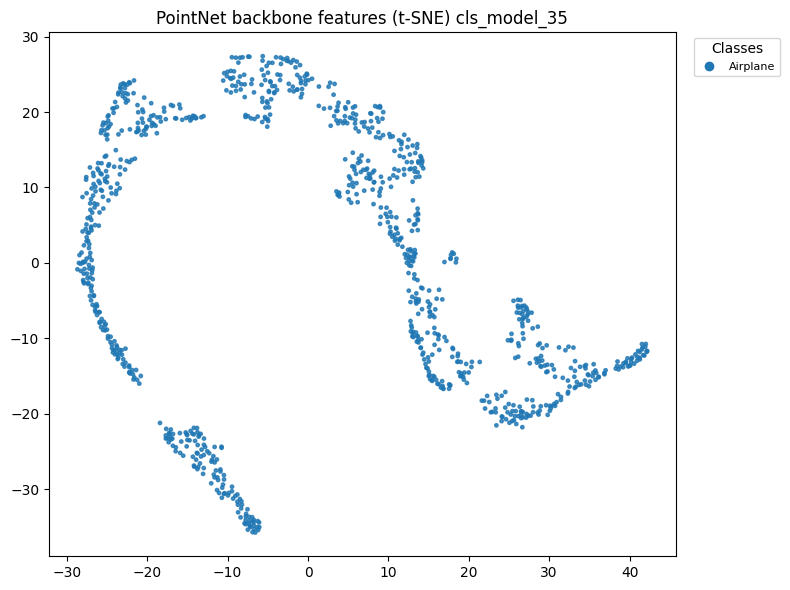

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2,
    metric='cosine',
    init='pca', # t is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data)
    learning_rate='auto',
    perplexity=30, #  Consider selecting a value between 5 and 50
    verbose=1
)
X2 = tsne.fit_transform(X)

# plot
idx_by_name = sorted(test_dataset.classes.items(), key=lambda kv: kv[1])
class_names = [n for n,_ in idx_by_name]
num_classes = len(class_names)

plt.figure(figsize=(8,6))
sc = plt.scatter(X2[:,0], X2[:,1], c=y, cmap='tab20', s=6, alpha=0.8)
handles = [plt.Line2D([],[], marker='o', linestyle='', color=plt.cm.tab20(i),
                      label=class_names[i]) for i in range(num_classes)]
plt.legend(handles=handles, bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8, title='Classes')
plt.title('PointNet backbone features (t-SNE) cls_model_35')
plt.tight_layout()
plt.show()


In [18]:
# 1) Grab one classification sample
random_idx = np.random.randint(len(test_dataset))
points, cls_label = test_dataset[random_idx]     # points: (N, 3), cls_label: scalar
points = points.to(DEVICE)

# 2) Forward pass to get logits and critical indices
with torch.no_grad():
    logits, crit_idxs, _ = classifier35(points.unsqueeze(0).transpose(2, 1))  # crit_idxs: (1, C)
    crit_idxs = crit_idxs[0]                                                # (C,)
    crit_idxs = torch.unique(crit_idxs)                                     # unique indices

# 3) Build point clouds for visualization
all_pts  = points.cpu().numpy()                   # (N, 3)
crit_pts = all_pts[crit_idxs.cpu().numpy()]       # (M, 3) with M <= C

# Open3D requires colors in [0, 1]
import open3d as o3
import numpy as np

grey = np.array([0.7, 0.7, 0.7])
red  = np.array([1.0, 0.0, 0.0])

pc_all = o3.geometry.PointCloud()
pc_all.points = o3.utility.Vector3dVector(all_pts)
pc_all.colors = o3.utility.Vector3dVector(np.repeat(grey[None, :], all_pts.shape[0], axis=0))

pc_crit = o3.geometry.PointCloud()
pc_crit.points = o3.utility.Vector3dVector(crit_pts)
pc_crit.colors = o3.utility.Vector3dVector(np.repeat(red[None, :], crit_pts.shape[0], axis=0))

o3.visualization.draw_plotly([pc_all, pc_crit])   # or draw(pc_all); draw(pc_crit) locally


### Other classifier model:

### cls_model_37

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000335
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.927395
[t-SNE] KL divergence after 1000 iterations: 0.494219


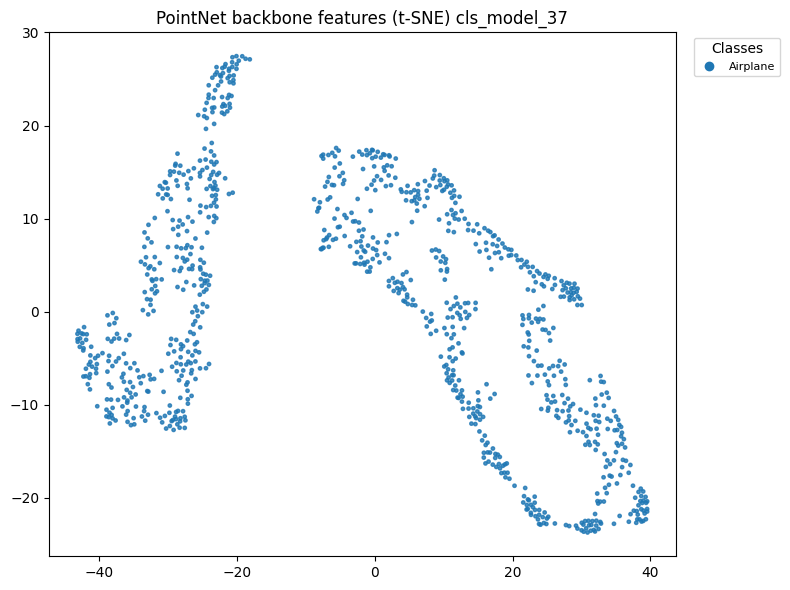

In [19]:
from point_net import PointNetClassHead
MODEL_PATH = 'trained_models/cls_focal_clr/cls_model_37.pth'

classifier37 = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier37.load_state_dict(torch.load(MODEL_PATH))
classifier37.eval();


all_feats = []
all_labels = []

with torch.no_grad():
    for pts, labels in test_dataloader:           # pts: (B, N, 3)
        x = pts.transpose(2, 1).to(DEVICE)        # -> (B, 3, N)
        # run ONLY the backbone
        gfeat, crit_idxs, _ = classifier37.backbone(x)   # gfeat: (B, 1024)
        # gfeat = torch.nn.functional.normalize(gfeat, p=2, dim=1)  # optional L2
        all_feats.append(gfeat.cpu().numpy())
        all_labels.append(labels.squeeze(1).cpu().numpy())

X = np.vstack(all_feats)          # (num_samples, 1024)
y = np.concatenate(all_labels)    # (num_samples,)

X2 = tsne.fit_transform(X)

# plot
idx_by_name = sorted(test_dataset.classes.items(), key=lambda kv: kv[1])
class_names = [n for n,_ in idx_by_name]
num_classes = len(class_names)

plt.figure(figsize=(8,6))
sc = plt.scatter(X2[:,0], X2[:,1], c=y, cmap='tab20', s=6, alpha=0.8)
handles = [plt.Line2D([],[], marker='o', linestyle='', color=plt.cm.tab20(i),
                      label=class_names[i]) for i in range(num_classes)]
plt.legend(handles=handles, bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8, title='Classes')
plt.title('PointNet backbone features (t-SNE) cls_model_37')
plt.tight_layout()
plt.show()

In [20]:
# 2) Forward pass to get logits and critical indices
with torch.no_grad():
    logits, crit_idxs, _ = classifier37(points.unsqueeze(0).transpose(2, 1))  # crit_idxs: (1, C)
    crit_idxs = crit_idxs[0]                                                # (C,)
    crit_idxs = torch.unique(crit_idxs)                                     # unique indices

# 3) Build point clouds for visualization
all_pts  = points.cpu().numpy()                   # (N, 3)
crit_pts = all_pts[crit_idxs.cpu().numpy()]       # (M, 3) with M <= C

# Open3D requires colors in [0, 1]
import open3d as o3
import numpy as np

grey = np.array([0.7, 0.7, 0.7])
red  = np.array([1.0, 0.0, 0.0])

pc_all = o3.geometry.PointCloud()
pc_all.points = o3.utility.Vector3dVector(all_pts)
pc_all.colors = o3.utility.Vector3dVector(np.repeat(grey[None, :], all_pts.shape[0], axis=0))

pc_crit = o3.geometry.PointCloud()
pc_crit.points = o3.utility.Vector3dVector(crit_pts)
pc_crit.colors = o3.utility.Vector3dVector(np.repeat(red[None, :], crit_pts.shape[0], axis=0))

o3.visualization.draw_plotly([pc_all, pc_crit])   # or draw(pc_all); draw(pc_crit) locally


### cls_model_38

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.572201
[t-SNE] KL divergence after 1000 iterations: 0.482628


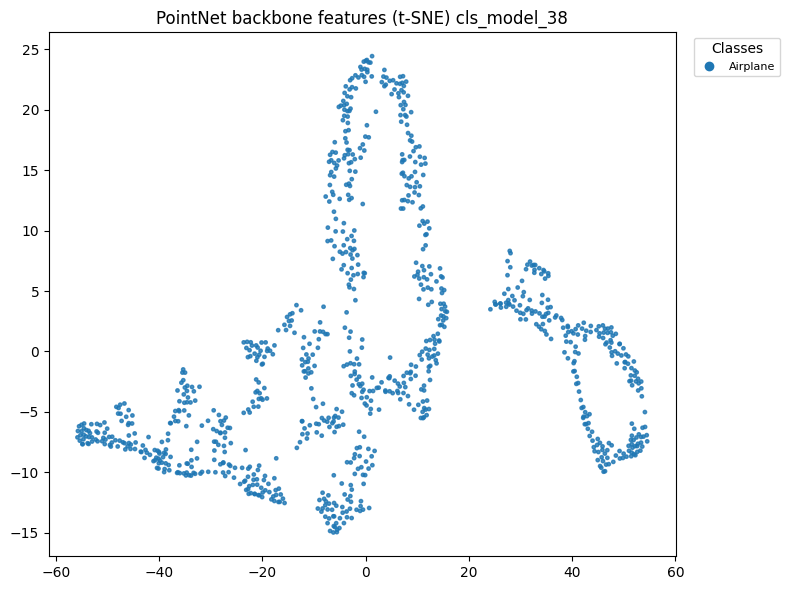

In [21]:
from point_net import PointNetClassHead
MODEL_PATH = 'trained_models/cls_focal_clr/cls_model_38.pth'

classifier38 = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier38.load_state_dict(torch.load(MODEL_PATH))
classifier38.eval();


all_feats = []
all_labels = []

with torch.no_grad():
    for pts, labels in test_dataloader:           # pts: (B, N, 3)
        x = pts.transpose(2, 1).to(DEVICE)        # -> (B, 3, N)
        # run ONLY the backbone
        gfeat, crit_idxs, _ = classifier38.backbone(x)   # gfeat: (B, 1024)
        # gfeat = torch.nn.functional.normalize(gfeat, p=2, dim=1)  # optional L2
        all_feats.append(gfeat.cpu().numpy())
        all_labels.append(labels.squeeze(1).cpu().numpy())

X = np.vstack(all_feats)          # (num_samples, 1024)
y = np.concatenate(all_labels)    # (num_samples,)

X2 = tsne.fit_transform(X)

# plot
idx_by_name = sorted(test_dataset.classes.items(), key=lambda kv: kv[1])
class_names = [n for n,_ in idx_by_name]
num_classes = len(class_names)

plt.figure(figsize=(8,6))
sc = plt.scatter(X2[:,0], X2[:,1], c=y, cmap='tab20', s=6, alpha=0.8)
handles = [plt.Line2D([],[], marker='o', linestyle='', color=plt.cm.tab20(i),
                      label=class_names[i]) for i in range(num_classes)]
plt.legend(handles=handles, bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8, title='Classes')
plt.title('PointNet backbone features (t-SNE) cls_model_38')
plt.tight_layout()
plt.show()

In [22]:
# 2) Forward pass to get logits and critical indices
with torch.no_grad():
    logits, crit_idxs, _ = classifier38(points.unsqueeze(0).transpose(2, 1))  # crit_idxs: (1, C)
    crit_idxs = crit_idxs[0]                                                # (C,)
    crit_idxs = torch.unique(crit_idxs)                                     # unique indices

# 3) Build point clouds for visualization
all_pts  = points.cpu().numpy()                   # (N, 3)
crit_pts = all_pts[crit_idxs.cpu().numpy()]       # (M, 3) with M <= C

# Open3D requires colors in [0, 1]
import open3d as o3
import numpy as np

grey = np.array([0.7, 0.7, 0.7])
red  = np.array([1.0, 0.0, 0.0])

pc_all = o3.geometry.PointCloud()
pc_all.points = o3.utility.Vector3dVector(all_pts)
pc_all.colors = o3.utility.Vector3dVector(np.repeat(grey[None, :], all_pts.shape[0], axis=0))

pc_crit = o3.geometry.PointCloud()
pc_crit.points = o3.utility.Vector3dVector(crit_pts)
pc_crit.colors = o3.utility.Vector3dVector(np.repeat(red[None, :], crit_pts.shape[0], axis=0))

o3.visualization.draw_plotly([pc_all, pc_crit])   # or draw(pc_all); draw(pc_crit) locally


### cls_model_15

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.199627
[t-SNE] KL divergence after 1000 iterations: 0.635289


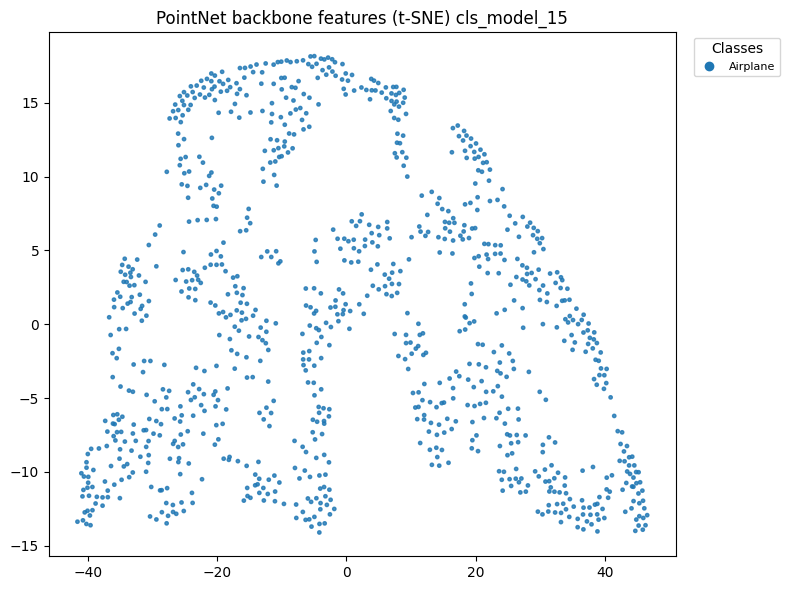

In [23]:
from point_net import PointNetClassHead
MODEL_PATH = 'trained_models/cls_focal/cls_model_15.pth'

classifier15 = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier15.load_state_dict(torch.load(MODEL_PATH))
classifier15.eval();


all_feats = []
all_labels = []

with torch.no_grad():
    for pts, labels in test_dataloader:           # pts: (B, N, 3)
        x = pts.transpose(2, 1).to(DEVICE)        # -> (B, 3, N)
        # run ONLY the backbone
        gfeat, crit_idxs, _ = classifier15.backbone(x)   # gfeat: (B, 1024)
        # gfeat = torch.nn.functional.normalize(gfeat, p=2, dim=1)  # optional L2
        all_feats.append(gfeat.cpu().numpy())
        all_labels.append(labels.squeeze(1).cpu().numpy())

X = np.vstack(all_feats)          # (num_samples, 1024)
y = np.concatenate(all_labels)    # (num_samples,)

X2 = tsne.fit_transform(X)

# plot
idx_by_name = sorted(test_dataset.classes.items(), key=lambda kv: kv[1])
class_names = [n for n,_ in idx_by_name]
num_classes = len(class_names)

plt.figure(figsize=(8,6))
sc = plt.scatter(X2[:,0], X2[:,1], c=y, cmap='tab20', s=6, alpha=0.8)
handles = [plt.Line2D([],[], marker='o', linestyle='', color=plt.cm.tab20(i),
                      label=class_names[i]) for i in range(num_classes)]
plt.legend(handles=handles, bbox_to_anchor=(1.02,1), loc='upper left', fontsize=8, title='Classes')
plt.title('PointNet backbone features (t-SNE) cls_model_15')
plt.tight_layout()
plt.show()

In [24]:
# 2) Forward pass to get logits and critical indices
with torch.no_grad():
    logits, crit_idxs, _ = classifier15(points.unsqueeze(0).transpose(2, 1))  # crit_idxs: (1, C)
    crit_idxs = crit_idxs[0]                                                # (C,)
    crit_idxs = torch.unique(crit_idxs)                                     # unique indices

# 3) Build point clouds for visualization
all_pts  = points.cpu().numpy()                   # (N, 3)
crit_pts = all_pts[crit_idxs.cpu().numpy()]       # (M, 3) with M <= C

# Open3D requires colors in [0, 1]
import open3d as o3
import numpy as np

grey = np.array([0.7, 0.7, 0.7])
red  = np.array([1.0, 0.0, 0.0])

pc_all = o3.geometry.PointCloud()
pc_all.points = o3.utility.Vector3dVector(all_pts)
pc_all.colors = o3.utility.Vector3dVector(np.repeat(grey[None, :], all_pts.shape[0], axis=0))

pc_crit = o3.geometry.PointCloud()
pc_crit.points = o3.utility.Vector3dVector(crit_pts)
pc_crit.colors = o3.utility.Vector3dVector(np.repeat(red[None, :], crit_pts.shape[0], axis=0))

o3.visualization.draw_plotly([pc_all, pc_crit])   # or draw(pc_all); draw(pc_crit) locally
